ARTISTIC STYLE TRANSFER

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import os
os.chdir("drive/nst1")

In [0]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
%matplotlib inline

### Code

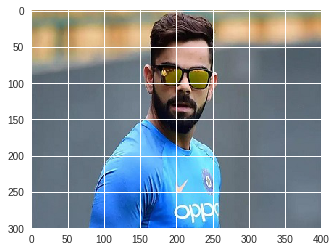

In [4]:
img = scipy.misc.imread('images/virat.jpg')
org_img=scipy.misc.imread('images/virat.jpg')
or_img=scipy.misc.imread('images/virat.jpg')
imshow(img)

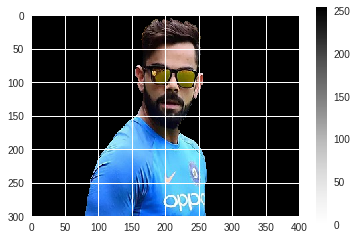

In [6]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (50,0,300,300)                                        
cv.grabCut(img,mask,rect,bgdModel,fgdModel,10,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img1 = img*mask2[:,:,np.newaxis]
plt.imshow(img1),plt.colorbar(),plt.show()
scipy.misc.imsave('images/img1.jpg', img1)
img_fore=img1

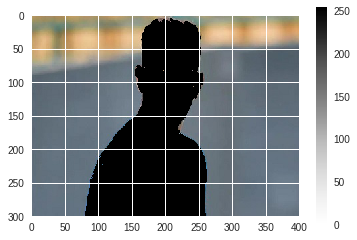

(<matplotlib.image.AxesImage at 0x7ffac856dd30>,
 None)

In [7]:
background = img - img_fore
background[np.where((background == [255,255,255]).all(axis = 2))] =[0,0,0]
final = background + img1
background2=background
plt.imshow(background),plt.colorbar(),plt.show() 

In [0]:
nimg=or_img
for i in range(1,299):
  for j in range(1,399):
    if img_fore[i,j,0]>0:
      nimg[i,j,0]=1
      nimg[i,j,1]=1
      nimg[i,j,2]=1
    else:
      nimg[i,j,0]=0
      nimg[i,j,1]=0
      nimg[i,j,2]=0

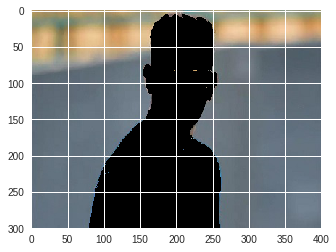

In [9]:
mul_back=org_img
for i in range(1,299):
  for j in range(1,399):
    if background[i,j,0]>0:
      mul_back[i,j,0]=1
      mul_back[i,j,1]=1
      mul_back[i,j,2]=1
    else:
      mul_back[i,j,0]=0
      mul_back[i,j,1]=0
      mul_back[i,j,2]=0
      
imshow(background)

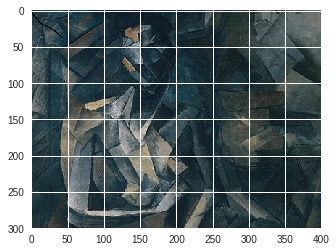

In [80]:
OUTPUT_DIR = 'output/'
STYLE_IMAGE = 'images/picasso.jpg'
CONTENT_IMAGE = load_image('images/eiffel.jpg')
IMAGE_WIDTH = 400
IMAGE_HEIGHT = 300
COLOR_CHANNELS = 3
styleimg = scipy.misc.imread('images/picasso.jpg')
imshow(styleimg)

In [81]:
NOISE_RATIO = 0.2
# Constant to put more emphasis on content loss.
BETA = 10
# Constant to put more emphasis on style loss.
ALPHA = 50
 
VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat'
# The mean to subtract from the input to the VGG model. This is the mean that
# when the VGG was used to train..
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
print(CONTENT_IMAGE.shape)

(1, 300, 400, 3)



We will use the VGG19 model. 

In [0]:
CONTENT_LAYERS = [
    ('conv4_2', 1.0),
    ('conv5_2', 1.0),
    ('conv1_2', 1.0),
    ('conv2_2', 1.0),
    ('conv3_2', 1.0),
]

def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper.
    """
    def _content_loss(p, x):
        # N is the number of filters (at layer l).
        N = p.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = p.shape[1] * p.shape[2]
        
        return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2))
    
    E = [_content_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in CONTENT_LAYERS]
    W = [w for _, w in CONTENT_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(CONTENT_LAYERS))])
    return loss

In [0]:
STYLE_LAYERS = [
    ('conv1_1', 4.0),
    ('conv2_1', 3.0),
    ('conv3_1', 2.5),
    ('conv4_1', 1.5),
    ('conv5_1', 1.0),
#     ('conv6_1', 1.0),
#     ('conv7_1', 1.0),
]

def style_loss_func(sess, model):

    def _gram_matrix(F, N, M):
        """
        The gram matrix G.
        """
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(a, x):
        """
        The style loss calculation.
        """
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        # A is the style representation of the original image (at layer l).
        A = _gram_matrix(a, N, M)
        # G is the style representation of the generated image (at layer l).
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

Define the rest of the auxiliary functions.

In [0]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
   
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def load_image(path):
    image = scipy.misc.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

def save_image_mix(path, image):
    # Output should add back the mean.
    image = image 
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)    

Create an TensorFlow session.

In [0]:
sess = tf.InteractiveSession()

In [0]:
content_image = CONTENT_IMAGE


In [0]:
style_image = load_image(STYLE_IMAGE)
#imshow(style_image)

Build the model now.

In [0]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [0]:
#input_image = np.random.rand(*CONTENT_IMAGE.shape) + 128 
input_image = generate_noise_image(content_image)
#imshow(input_image[0])

In [0]:
sess.run(tf.initialize_all_variables())

In [0]:
# Construct content_loss using content_image.
sess.run(model['input'].assign(content_image))
content_loss = content_loss_func(sess, model)

In [0]:
# Construct style_loss using style_image.
sess.run(model['input'].assign(style_image))
style_loss = style_loss_func(sess, model)

In [0]:
total_loss = BETA * content_loss + ALPHA * style_loss

In [0]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

In [94]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))

array([[[[-43.50531   , -21.450748  ,  51.43989   ],
         [-43.39627   , -16.981533  ,  49.828865  ],
         [-37.77495   , -16.00873   ,  58.954636  ],
         ...,
         [  7.508057  ,  26.464024  ,  82.102684  ],
         [  9.520271  ,  32.13671   ,  80.31054   ],
         [ 10.276834  ,  24.856468  ,  82.756065  ]],

        [[-38.98934   , -12.988597  ,  49.699783  ],
         [-39.722775  ,  -8.702171  ,  56.67054   ],
         [-37.869274  ,  -8.443401  ,  60.222668  ],
         ...,
         [ 10.522684  ,  27.298159  ,  85.61068   ],
         [  7.8261743 ,  31.420614  ,  82.918365  ],
         [  8.594186  ,  26.034048  ,  80.120026  ]],

        [[-40.09963   , -16.222345  ,  53.15751   ],
         [-38.931667  , -15.63918   ,  58.21177   ],
         [-38.10145   ,  -8.410697  ,  55.554134  ],
         ...,
         [  7.402318  ,  29.878328  ,  83.71716   ],
         [ 13.079518  ,  34.168762  ,  84.0167    ],
         [  7.399629  ,  25.84146   ,  80.35279   ]],

In [0]:
# Number of iterations to run.
ITERATIONS = 1000  

In [78]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))
for it in range(ITERATIONS):
    sess.run(train_step)

    
    if it%100 == 0:
        # Print every 100 iteration.
        mixed_image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
        print('cost: ', sess.run(total_loss))
        #print('content loss:', sess.run(content_loss))

        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (it)
        
        #save_image(filename, mixed_image)
        save_image(filename, mixed_image)

Iteration 0
sum :  14020316.0
cost:  151803740000.0
Iteration 100
sum :  11939317.0
cost:  7613823000.0
Iteration 200
sum :  10225360.0
cost:  4062009000.0
Iteration 300
sum :  8834525.0
cost:  2777639700.0
Iteration 400
sum :  7622978.0
cost:  2076681100.0
Iteration 500
sum :  6538082.0
cost:  1633457800.0
Iteration 600
sum :  5548391.5
cost:  1337355500.0
Iteration 700
sum :  4629388.0
cost:  1126747800.0
Iteration 800
sum :  3769993.2
cost:  968516600.0
Iteration 900
sum :  2958923.5
cost:  845286850.0


In [0]:
save_image('output/spice_eiffel.jpg',mixed_image)

In [0]:
save_image('output/art_stylepicasso_virat-convall-nr0.2-5-100.jpg', mixed_image)

In [0]:
mix=scipy.misc.imread('output/art_stylefedro_virat.jpg')

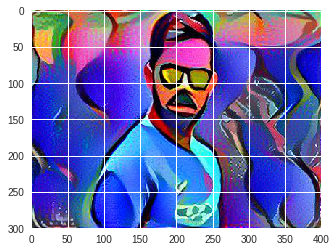

In [70]:
imshow(mix)

In [0]:
mix1=mix*nimg

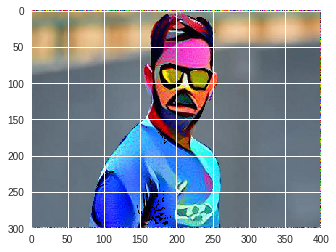

In [22]:
mix2=mix1+background
imshow(mix2)

In [0]:
scipy.misc.imsave('output/semantic_art_foreground3_styleguernicavirat.jpg', mix2)

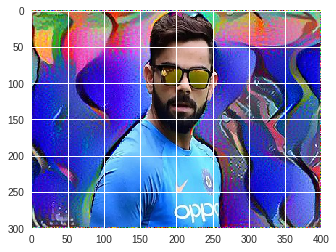

In [24]:
back_mix1=mix*mul_back
back_mix2=back_mix1+img1
imshow(back_mix2)

In [0]:
scipy.misc.imsave('output/semantic_art_background_styleguernicavirat.jpg', back_mix2)